In [1]:
cd ../analysis/

/home/jlee782/hcomp_paper_seg/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from withClustAnalysis import *
from hcomp_paper_viz import *

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# Run once
#from qualityBaseline import compute_self_BBvals
# print "generate baseline comparisons"
# compute_self_BBvals(compute_metrics=['simple','area']) #run once
# retreival_df = compute_best_average_heuristics_workers_baselines(rerun_existing=True) #run once

# Retreival based heuristic models

-  if we only pick from the best cluster, if no clustering done then retain the same worker performance as before

In [4]:
from baseline import compute_worker_qualities_against_real_performance

In [5]:
obj_clusters = clusters()

In [6]:
clust_df = pd.read_csv("spectral_clustering_all_hard_obj.csv")
noClust_obj =[obj for obj in object_lst if obj not in clust_df.objid.unique() ]
clustObj = clust_df.objid.unique()

In [7]:
retreival_df= pd.read_csv("pixel_em/individual_worker_performance.csv")
retreival_df["sample_num"]=retreival_df.apply(lambda x:int(x["sample"].split("rand")[-1]),axis=1)
no_cluster_retreival_df = retreival_df[retreival_df["clust"]==-1]
cluster_retreival_df = retreival_df[((retreival_df["clust"]!=-1) & (retreival_df["objid"].isin(clustObj)))|((retreival_df["clust"]==-1) & (~retreival_df["objid"].isin(clustObj)))]

In [8]:
#BAD!
# best_clust_df = compute_best_worker_picking()
# cluster_retreival_df=filter_best_clust(retreival_df,best_clust_df)

In [9]:
def best_cluster(x):
    try:
        return obj_clusters[x["sample"]][str(x["objid"])]
    except(KeyError): #non clustered cases
        return -1

retreival_df["best_clust"]=retreival_df.apply(lambda x: best_cluster(x),axis=1)
cluster_retreival_df = retreival_df[retreival_df["best_clust"]==retreival_df["clust"]]
assert len(cluster_retreival_df.groupby(["sample","objid"]).count())==46*31

In [10]:
retreivalAlgoMap={
    'NumPt':'orange',
    'AreaRatio':'green',
    'AvrgWorker':'blue',
    'BestWorker':'red'
}

For vision, we scan a variety of inclusion thresholds as well as different levels of segmentation granularities. For each object, we pick parameter that yields the best performing Jaccard.

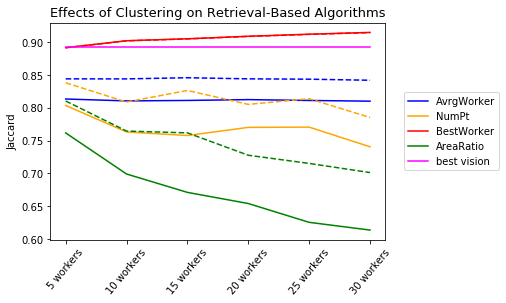

In [11]:
vision = pd.read_csv("pixel_em/vision_only_performance.csv")

NworkerPerformance = no_cluster_retreival_df.groupby("num_workers").mean()
for algo in retreivalAlgoMap.keys():
    algoJ = "J [{}]".format(algo)
    plt.plot(np.array(NworkerPerformance[algoJ]),label=algo,color=retreivalAlgoMap[algo])

NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
for algo in  retreivalAlgoMap.keys():
    algoJ = "J [{}]".format(algo)
    plt.plot(np.array(NworkerPerformance[algoJ]),linestyle='--',color=retreivalAlgoMap[algo])

max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
y = np.ones_like(np.array(NworkerPerformance[algoJ]))
plt.plot(y*max_vision_k_thresh,label="best vision",color="magenta")
lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
#plt.legend(loc="lower left",fontsize=8)    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Effects of Clustering on Retrieval-Based Algorithms",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.savefig("ClusteringEffectOnRetreival.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [12]:
from tabulate import tabulate

In [13]:
megadfd =[]
for algo in retreivalAlgoMap.keys():
    keys = ['P [{}]'.format(algo), u'R [{}]'.format(algo), 'J [{}]'.format(algo), u'FPR% [{}]'.format(algo),'FNR% [{}]'.format(algo)]
    performance = list(cluster_retreival_df.mean()[keys])
    lst = [algo]
    lst.extend(performance)
    megadfd.append(lst)

In [14]:
megadf = pd.DataFrame(megadfd, columns=["algo","P","R","J","FPR%","FNR%"])

In [15]:
print tabulate(megadf,showindex=False,headers=megadf.columns,tablefmt="latex",floatfmt=".2f")

\begin{tabular}{lrrrrr}
\hline
 algo       &    P &    R &    J &   FPR\% &   FNR\% \\
\hline
 AvrgWorker & 0.91 & 0.92 & 0.84 &   7.94 &   0.52 \\
 NumPt      & 0.87 & 0.92 & 0.82 &   7.86 &   1.10 \\
 BestWorker & 0.95 & 0.95 & 0.90 &   5.23 &   0.17 \\
 AreaRatio  & 0.79 & 0.94 & 0.77 &   5.51 &   2.06 \\
\hline
\end{tabular}


- add MV in this plot 
- leave out clustering for this 

# Comparing MV with EM ; clust v.s. no clust

In [16]:
from analyze_prjs import clust_vs_noclust

In [17]:
algoMap = {
    'GTLSA':'orange',
    "basic":'green',
    "GT":'blue',
    "isoGT":'red',
    "isoGTLSA": 'cyan',
    "isobasic": 'magenta',
    "MV":"black"
}

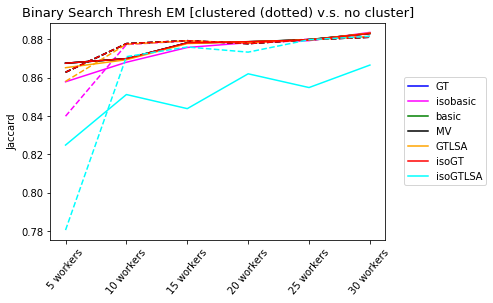

In [18]:
for algo in algoMap.keys():
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    x,algo_noclust,algo_clust=clust_vs_noclust(algo,filtered=False)
    plt.plot(algo_noclust,label=algo,color = algoMap[algo])
    plt.plot(algo_clust,linestyle="--",color = algoMap[algo])
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Binary Search Thresh EM [clustered (dotted) v.s. no cluster]",fontsize=13)

basic, isoGT and GT are all very close to MV

In [19]:
def avrg_percent_change(clust,noClust):
    return "{:.3f}%".format(np.mean((np.array(clust)-np.array(noClust))/np.array(noClust))*100)

__Comparing cluster v.s. no cluster__

In [20]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change due to clustering for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    print "{} :{}".format("MV",avrg_percent_change(MV_clust,MV_noclust))
    for algo in algoMap.keys():
        x,algo_noclust,algo_clust=clust_vs_noclust(algo,metric=metric,filtered=False)
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,algo_noclust))

------------
percent change due to clustering for metric: precision
MV :-0.110%
GT :-0.066%
isobasic :-0.080%
basic :-0.063%
MV :-0.110%
GTLSA :-0.091%
isoGT :-0.066%
isoGTLSA :0.973%
------------
percent change due to clustering for metric: recall
MV :-0.035%
GT :0.005%
isobasic :0.058%
basic :0.005%
MV :-0.035%
GTLSA :-0.071%
isoGT :0.005%
isoGTLSA :0.744%
------------
percent change due to clustering for metric: jaccard
MV :0.024%
GT :0.028%
isobasic :-0.137%
basic :0.030%
MV :0.024%
GTLSA :0.005%
isoGT :0.028%
isoGTLSA :1.120%
------------
percent change due to clustering for metric: FNR%
MV :0.793%
GT :0.295%
isobasic :-0.436%
basic :0.292%
MV :0.793%
GTLSA :1.177%
isoGT :0.295%
isoGTLSA :-8.477%
------------
percent change due to clustering for metric: FPR%
MV :10.345%
GT :22.859%
isobasic :3.464%
basic :22.729%
MV :10.345%
GTLSA :6.866%
isoGT :22.859%
isoGTLSA :-37.079%


__Comparing cluster (best) v.s. MV__

In [21]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change compared to MV for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    for algo in algoMap.keys():
        x,algo_noclust,algo_clust=clust_vs_noclust(algo,metric=metric,filtered=False)
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,MV_clust))

------------
percent change compared to MV for metric: precision
GT :0.041%
isobasic :-0.360%
basic :0.043%
MV :0.000%
GTLSA :-0.028%
isoGT :0.041%
isoGTLSA :-1.901%
------------
percent change compared to MV for metric: recall
GT :0.040%
isobasic :0.012%
basic :0.041%
MV :0.000%
GTLSA :-0.070%
isoGT :0.040%
isoGTLSA :0.053%
------------
percent change compared to MV for metric: jaccard
GT :0.002%
isobasic :-0.437%
basic :0.005%
MV :0.000%
GTLSA :-0.082%
isoGT :0.002%
isoGTLSA :-1.859%
------------
percent change compared to MV for metric: FNR%
GT :-0.432%
isobasic :-0.153%
basic :-0.449%
MV :0.000%
GTLSA :0.743%
isoGT :-0.432%
isoGTLSA :-0.588%
------------
percent change compared to MV for metric: FPR%
GT :11.171%
isobasic :133.921%
basic :11.083%
MV :0.000%
GTLSA :-2.011%
isoGT :11.171%
isoGTLSA :703.547%


# Greedy Results

In [22]:
greedy_df = pd.read_csv("all_greedy_result.csv")
greedy_df["num_workers"]=greedy_df.apply(lambda x:int(x["sample"].split("workers")[0]),axis=1)
greedy_df["sample_num"] = greedy_df.apply(lambda x: int(x["sample"].split("rand")[-1]),axis=1)
greedy_noclust=greedy_df[greedy_df["clust"]==-1]
best_clust_df=compute_best_worker_picking()
greedy_clust= filter_best_clust(greedy_df,best_clust_df)
assert greedy_noclust.groupby(["sample"])["objid"].count().unique()[0]==8*46

In [23]:
greedyAlgoMap = {
    'GTLSA':'orange',
    "basic":'green',
    "GT":'blue',
    "isoGT":'red',
    "isoGTLSA": 'cyan',
    "isobasic": 'magenta',
    "worker_fraction": 'pink',
    "ground_truth": 'yellow'
}

In [24]:
from analyze_prjs import clust_vs_noclust

(0.82, 0.99)

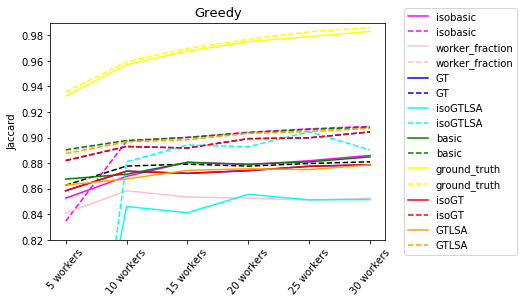

In [25]:
x,MV_noclust,MV_clust=clust_vs_noclust('MV',filtered=False)

# plt.plot(MV_noclust,label="MV",color="black")
plt.plot(MV_clust,color="black",linestyle="--")

for algo in greedyAlgoMap.keys():
    algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()["j"])
    algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()["j"])
    plt.plot(algo_noClust,label=algo,color=greedyAlgoMap[algo])
    plt.plot(algo_clust,color=greedyAlgoMap[algo],label=algo,linestyle='--')
    
    
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Greedy",fontsize=13)
plt.ylim(0.82,0.99)

In [26]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change due to clustering for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    print "{} :{}".format("MV",avrg_percent_change(MV_clust,MV_noclust))
    for algo in greedyAlgoMap.keys():
        algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,algo_noClust))

------------
percent change due to clustering for metric: precision
MV :-0.110%
isobasic :0.173%
worker_fraction :5.077%
GT :1.664%
isoGTLSA :1.270%
basic :0.918%
ground_truth :0.173%
isoGT :1.664%
GTLSA :1.797%
------------
percent change due to clustering for metric: recall
MV :-0.035%
isobasic :1.688%
worker_fraction :0.376%
GT :0.939%
isoGTLSA :1.660%
basic :1.872%
ground_truth :0.121%
isoGT :0.939%
GTLSA :1.337%
------------
percent change due to clustering for metric: jaccard
MV :0.024%
isobasic :1.924%
worker_fraction :5.729%
GT :2.591%
isoGTLSA :2.397%
basic :2.701%
ground_truth :0.283%
isoGT :2.591%
GTLSA :3.124%
------------
percent change due to clustering for metric: FNR%
MV :0.793%
isobasic :-21.829%
worker_fraction :-6.609%
GT :-20.006%
isoGTLSA :-22.815%
basic :-24.468%
ground_truth :-7.418%
isoGT :-20.006%
GTLSA :-18.873%
------------
percent change due to clustering for metric: FPR%
MV :10.345%
isobasic :39.715%
worker_fraction :-80.563%
GT :-19.042%
isoGTLSA :-39.104%

In [27]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change compared to MV for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    for algo in greedyAlgoMap.keys():
        algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,MV_clust))

------------
percent change compared to MV for metric: precision
isobasic :0.005%
worker_fraction :0.480%
GT :-1.474%
isoGTLSA :-6.788%
basic :0.968%
ground_truth :4.729%
isoGT :-1.474%
GTLSA :0.778%
------------
percent change compared to MV for metric: recall
isobasic :1.775%
worker_fraction :2.513%
GT :3.987%
isoGTLSA :2.224%
basic :2.091%
ground_truth :6.063%
isoGT :3.987%
GTLSA :2.118%
------------
percent change compared to MV for metric: jaccard
isobasic :1.767%
worker_fraction :2.731%
GT :2.133%
isoGTLSA :-5.147%
basic :2.826%
ground_truth :10.496%
isoGT :2.133%
GTLSA :2.651%
------------
percent change compared to MV for metric: FNR%
isobasic :-22.895%
worker_fraction :-31.828%
GT :-50.647%
isoGTLSA :-27.186%
basic :-26.470%
ground_truth :-77.797%
isoGT :-50.647%
GTLSA :-26.917%
------------
percent change compared to MV for metric: FPR%
isobasic :290.284%
worker_fraction :-8.774%
GT :16.573%
isoGTLSA :2519.748%
basic :-16.443%
ground_truth :-74.942%
isoGT :16.573%
GTLSA :-14.

In [28]:
algo = "ground_truth"
algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()["j"])
algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()["j"])

print "When using ground truth to estimate intersection areas, we can achieve a Jaccard of {:.3f}".format(algo_noClust[-1]) ," as an upper bound with 30 workers, which indicates that with better probablistic estimation of intersection area, aggregation-based methods can achieve close to perfect estimation, exceeding the results of any single `best' worker."

When using ground truth to estimate intersection areas, we can achieve a Jaccard of 0.983  as an upper bound with 30 workers, which indicates that with better probablistic estimation of intersection area, aggregation-based methods can achieve close to perfect estimation, exceeding the results of any single `best' worker.


In [29]:
np.array(NworkerPerformance["J [BestWorker]"])[-1]

0.91425952589506532

# Combined plot

__Comparison between Retreival and families of aggregation based methods__

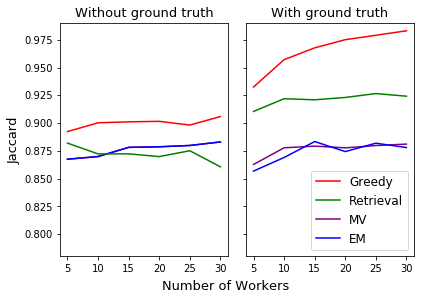

In [30]:
ax1= plt.subplot(121)
plt.title("Without ground truth",fontsize=13)
x,MV_noclust,MV_clust=clust_vs_noclust("MV",filtered=False)
x,MV_noclust_err,MV_clust_err=clust_vs_noclust("MV",filtered=False,aggFunc="median")
plt.plot(MV_noclust,color="purple",label="MV")
x,best_EM_noclust,best_EM_clust=clust_vs_noclust("basic",filtered=False)
x,best_EM_noclust_err,best_EM_clust_err=clust_vs_noclust("basic",filtered=False,aggFunc="median")
plt.plot(best_EM_noclust,color="blue",label="EM")

best_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="worker_fraction"].groupby(["num_workers"]).median()["j"])
plt.plot(best_greedy,color="red",label="greedy")
plt.ylabel("Jaccard",fontsize=13)
NworkerPerformance = cluster_retreival_df.groupby("num_workers").median()
# plt.plot(np.array(NworkerPerformance["J [AreaRatio]"]),color="orange",label="AreaRatio")
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),color="green",label="num points")
#plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),color="blue",label="average worker")
plt.ylim(0.78,0.99)

ax2 = plt.subplot(122,sharex=ax1,sharey=ax1)
plt.title("With ground truth",fontsize=13)
ground_truth_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="ground_truth"].groupby(["num_workers"]).mean()["j"])
plt.plot(ground_truth_greedy,linestyle="-",color="red",label="Greedy")
plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),linestyle="-",color="green",label="Retrieval")
# max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
# average_vision = vision.mean()["j"]
# y = np.ones_like(np.array(NworkerPerformance[algoJ]))
# plt.plot(y*average_vision,label="average vision",color="magenta")
# plt.plot(y*max_vision_k_thresh,linestyle=":",label="best vision",color="magenta")

#plt.legend(loc="lower left",fontsize=8)    
plt.plot(MV_clust,color="purple",label="MV",linestyle='-')
# plt.plot(best_EM_clust,color="blue",label="EM",linestyle='-')
x,best_EM_clust_gt,best_EM_noclust_gt=clust_vs_noclust("basic",filtered=False,ground_truth=True)
plt.plot(best_EM_noclust_gt,color="blue",label="EM")
plt.ylim(0.78,0.99)
# plt.xticks(rotation=50)
#plt.suptitle("Retreival v.s. Aggregation Algorithm Comparison",fontsize=13)
# lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.legend(loc="lower right",fontsize=12)
plt.xticks([0,1,2,3,4,5])
a = gca().set_xticklabels(['5','10','15','20','25','30'])
# make these tick labels invisible
plt.setp(ax2.get_yticklabels(), visible=False)

plt.text(-3,0.75,"Number of Workers",fontsize=13)
plt.tight_layout()
plt.savefig("Retreival_vs_Aggregation_NoClust.pdf", bbox_inches='tight')

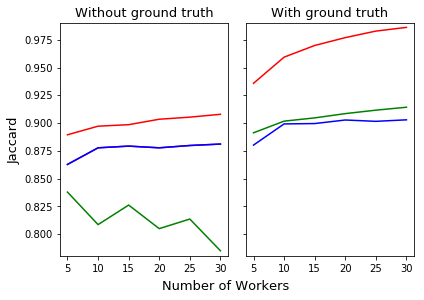

In [70]:
ax1= plt.subplot(121)
plt.title("Without ground truth",fontsize=13)
x,MV_noclust,MV_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(MV_clust,color="purple",label="MV")
x,best_EM_noclust,best_EM_clust=clust_vs_noclust("basic",filtered=False)
plt.plot(best_EM_clust,color="blue",label="EM")

best_greedy = np.array(greedy_clust[greedy_clust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
best_greedy_err = np.array(greedy_clust[greedy_clust["algo"]=="worker_fraction"].groupby(["num_workers"]).std()["j"])/2.
plt.plot(best_greedy,color="red",label="greedy")
plt.ylabel("Jaccard",fontsize=13)
NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
# plt.plot(np.array(NworkerPerformance["J [AreaRatio]"]),color="orange",label="AreaRatio")
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),color="green",label="num points")
#plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),color="blue",label="average worker")
plt.ylim(0.78,0.99)

ax2 = plt.subplot(122,sharex=ax1,sharey=ax1)
plt.title("With ground truth",fontsize=13)
ground_truth_greedy = np.array(greedy_clust[greedy_clust["algo"]=="ground_truth"].groupby(["num_workers"]).mean()["j"])
plt.plot(ground_truth_greedy,linestyle="-",color="red",label="Greedy")
plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),linestyle="-",color="green",label="Retrieval")
# max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
# average_vision = vision.mean()["j"]
# y = np.ones_like(np.array(NworkerPerformance[algoJ]))
# plt.plot(y*average_vision,label="average vision",color="magenta")
# plt.plot(y*max_vision_k_thresh,linestyle=":",label="best vision",color="magenta")

#plt.legend(loc="lower left",fontsize=8)    
# plt.plot(MV_clust,color="purple",label="MV",linestyle='-')
# plt.plot(best_EM_clust,color="blue",label="EM",linestyle='-')
x,best_EM_clust_gt,best_EM_noclust_gt=clust_vs_noclust("basic",filtered=False,ground_truth=True)
plt.plot(best_EM_clust_gt,color="blue",label="EM")

plt.ylim(0.78,0.99)
# plt.xticks(rotation=50)
#plt.suptitle("Retreival v.s. Aggregation Algorithm Comparison",fontsize=13)
# lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
# plt.legend(loc="lower right",fontsize=12)
plt.xticks([0,1,2,3,4,5])
a = gca().set_xticklabels(['5','10','15','20','25','30'])
# make these tick labels invisible
plt.setp(ax2.get_yticklabels(), visible=False)

plt.text(-3,0.75,"Number of Workers",fontsize=13)
plt.tight_layout()
plt.savefig("Retreival_vs_Aggregation_WiP.pdf", bbox_inches='tight')

In [32]:
EM_ground_truth_df = pd.read_csv("pixel_em/basic_ground_truth_cwgt.csv")

In [33]:
from analyze_prjs import *

In [34]:
all_data = read_ground_truth_algo_prj_table()

In [35]:
# all_data[5][0][10]

In [41]:
x,best_EM_clust_gt,best_EM_noclust_gt=clust_vs_noclust("basic",filtered=False,ground_truth=True)

In [42]:
best_clust = read_best_clust()

In [46]:
avrg_percent_change(best_EM_clust_gt,best_EM_noclust_gt)

'2.726%'

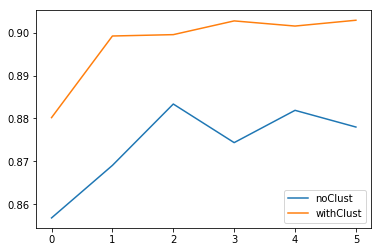

In [44]:
plt.plot(best_EM_noclust_gt,label="noClust")
plt.plot(best_EM_clust_gt,label="withClust")
plt.legend()

In [45]:
import glob

In [44]:
nworker_sample = []

for worker_file in glob.glob("pixel_em/*/obj*/clust*/worker_ids.json"):
    workers = json.load(open(worker_file))
    wsplit = worker_file.split("/")
    sample = wsplit[1]
    objid = int(wsplit[2][3:])
    clustid = int(wsplit[3][5:])
    nworkers =int(sample.split("workers")[0])
    sample_num =int(sample.split("rand")[-1])
    nworker_sample.append([sample,nworkers,sample_num,objid,clustid,len(workers)])

In [48]:
df = pd.DataFrame(nworker_sample,columns=["sample","num_workers","sample_num","objid","cluster","actualNworkerInSample"])

In [50]:
df.to_csv("actualNworkerInSampleForBestClustPicking.csv")

In [112]:
best = compute_best_worker_picking()

In [76]:
# EM_ground_truth_df[EM_ground_truth_df["clust"]==-1].groupby(["num_workers","sample_num"]).count()

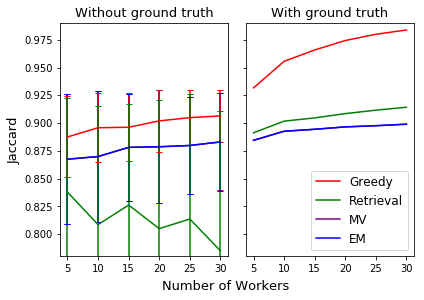

In [48]:
ax1= plt.subplot(121)
plt.title("Without ground truth",fontsize=13)
x,MV_noclust,MV_clust=clust_vs_noclust("MV",filtered=False)
x,MV_noclust_err,MV_clust_err=clust_vs_noclust("MV",filtered=False,aggFunc="errorbar")
plt.errorbar(range(6),MV_noclust,color="purple",label="MV",yerr=MV_noclust_err,capsize=3)
x,best_EM_noclust,best_EM_clust=clust_vs_noclust("basic",filtered=False)
x,best_EM_noclust_err,best_EM_clust_err=clust_vs_noclust("basic",filtered=False,aggFunc="errorbar")
plt.errorbar(range(6),best_EM_noclust,color="blue",label="EM", yerr=best_EM_noclust_err,capsize=3)

best_greedy = np.array(greedy_clust[greedy_clust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
best_greedy_err = np.array(greedy_clust[greedy_clust["algo"]=="worker_fraction"].groupby(["num_workers"]).std()["j"])/2.
plt.errorbar(range(6),best_greedy,color="red",label="greedy",yerr=best_greedy_err ,capsize=3)
plt.ylabel("Jaccard",fontsize=13)
NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
NworkerPerformance_err = cluster_retreival_df.groupby("num_workers").std()/2.
# plt.plot(np.array(NworkerPerformance["J [AreaRatio]"]),color="orange",label="AreaRatio")
plt.errorbar(range(6),np.array(NworkerPerformance["J [NumPt]"]),color="green",label="num points",yerr=np.array(NworkerPerformance_err["J [NumPt]"]) ,capsize=3)
#plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),color="blue",label="average worker")
plt.ylim(0.78,0.99)

ax2 = plt.subplot(122,sharex=ax1,sharey=ax1)
plt.title("With ground truth",fontsize=13)
ground_truth_greedy = np.array(greedy_clust[greedy_clust["algo"]=="ground_truth"].groupby(["num_workers"]).mean()["j"])
plt.plot(ground_truth_greedy,linestyle="-",color="red",label="Greedy")
plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),linestyle="-",color="green",label="Retrieval")
# max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
# average_vision = vision.mean()["j"]
# y = np.ones_like(np.array(NworkerPerformance[algoJ]))
# plt.plot(y*average_vision,label="average vision",color="magenta")
# plt.plot(y*max_vision_k_thresh,linestyle=":",label="best vision",color="magenta")

#plt.legend(loc="lower left",fontsize=8)    
plt.plot(MV_clust,color="purple",label="MV",linestyle='-')
plt.plot(best_EM_clust,color="blue",label="EM",linestyle='-')
plt.ylim(0.78,0.99)
# plt.xticks(rotation=50)
#plt.suptitle("Retreival v.s. Aggregation Algorithm Comparison",fontsize=13)
# lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.legend(loc="lower right",fontsize=12)
plt.xticks([0,1,2,3,4,5])
a = gca().set_xticklabels(['5','10','15','20','25','30'])
# make these tick labels invisible
plt.setp(ax2.get_yticklabels(), visible=False)

plt.text(-3,0.75,"Number of Workers",fontsize=13)
plt.tight_layout()
plt.savefig("Retreival_vs_Aggregation.pdf", bbox_inches='tight')

__Performance ratio of increase from 5 → 30 workers__

In [71]:
def worker_scaling_ratio(performance):
    return (performance[-1]-performance[0])/performance[0]*100

In [72]:
pchange=[]
for algo in  retreivalAlgoMap.keys():
    if algo!="AreaRatio":
        algoJ = "J [{}]".format(algo)
        performance = np.array(NworkerPerformance[algoJ])
        pchange.append([algo,worker_scaling_ratio(performance)])

In [73]:
pchange.append(["best greedy",worker_scaling_ratio(best_greedy)])
pchange.append(["best EM",worker_scaling_ratio(best_EM_clust)])
pchange.append(["ground truth greedy",worker_scaling_ratio(ground_truth_greedy)])
pchange.append(["MV",worker_scaling_ratio(algo_clust)])
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)

In [92]:
worker_scaling_ratio(best_EM_noclust)

1.7890576842396362

In [74]:
pchange=pd.DataFrame(np.array(pchange).T)

In [75]:
# pchange=pchange.transpose()

In [76]:
pchange.columns = pchange.iloc[0]
pchange.reindex(pchange.index.drop(0))

,AvrgWorker,NumPt,BestWorker,best greedy,best EM,ground truth greedy,MV
1,-0.251533707738,-6.30126685667,2.5795546392,2.07245595624,2.12401654609,5.37640166514,2.12401654609


In [77]:
# pchange.iloc[1]=round(pchange.iloc[1],2)

In [78]:
print tabulate(pchange,showindex=False,tablefmt="latex",floatfmt=".2f")

\begin{tabular}{lllllll}
\hline
 AvrgWorker      & NumPt          & BestWorker   & best greedy   & best EM       & ground truth greedy & MV            \\
 -0.251533707738 & -6.30126685667 & 2.5795546392 & 2.07245595624 & 2.12401654609 & 5.37640166514       & 2.12401654609 \\
\hline
\end{tabular}


__Effects of Clustering__

In [79]:
retreivalAlgoMap.keys()

['AvrgWorker', 'NumPt', 'BestWorker', 'AreaRatio']

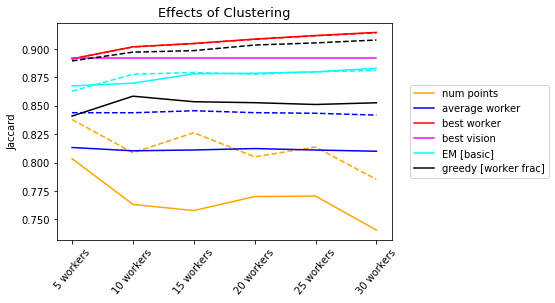

In [80]:
vision = pd.read_csv("pixel_em/vision_only_performance.csv")

NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),linestyle='--',color="orange")#,label="num points [c]")
plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),linestyle='--',color="blue")#,label="average worker [c]")
plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),linestyle='--',color="red")#,label="best worker [c]")

NworkerPerformance = no_cluster_retreival_df.groupby("num_workers").mean()
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),color="orange",label="num points")
plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),color="blue",label="average worker")
plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),color="red",label="best worker")

max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
y = np.ones_like(np.array(NworkerPerformance[algoJ]))
plt.plot(y*max_vision_k_thresh,label="best vision",color="magenta")

algo="basic"
x,algo_noclust,algo_clust=clust_vs_noclust(algo,filtered=False)
plt.plot(algo_noclust,label="EM [basic]",color = "cyan")
plt.plot(algo_clust,linestyle="--",color = "cyan")

best_greedy = np.array(greedy_clust[greedy_clust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
plt.plot(best_greedy,color="black",linestyle="--")
best_noclust_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
plt.plot(best_noclust_greedy,color="black",label="greedy [worker frac]")

lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
#plt.legend(loc="lower left",fontsize=8)    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Effects of Clustering",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.savefig("Effects_of_clustering.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [81]:
NworkerPerformance_noclust = no_cluster_retreival_df.groupby("num_workers").mean()
NworkerPerformance_with_clust = cluster_retreival_df.groupby("num_workers").mean()
numpt_no_clust = np.array(NworkerPerformance_noclust["J [NumPt]"])
numpt_with_clust = np.array(NworkerPerformance_with_clust["J [NumPt]"])
bestworker_no_clust = np.array(NworkerPerformance_noclust["J [BestWorker]"])
bestworker_with_clust = np.array(NworkerPerformance_with_clust["J [BestWorker]"])

best_greedy_clust = np.array(greedy_clust[greedy_clust["algo"]=="ground_truth"].groupby(["num_workers"]).mean()["j"])
best_noclust_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="ground_truth"].groupby(["num_workers"]).mean()["j"])
greedy = np.array(greedy_clust[greedy_clust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
noclust_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="worker_fraction"].groupby(["num_workers"]).mean()["j"])
x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)

pchange_data = [] 
pchange_data.append(["best worker",avrg_percent_change(bestworker_with_clust,bestworker_no_clust)])
pchange_data.append(["numpt",avrg_percent_change(numpt_with_clust,numpt_no_clust)])
pchange_data.append(["MV",avrg_percent_change(MV_clust,MV_noclust)])
pchange_data.append(["greedy", avrg_percent_change(greedy,noclust_greedy)])
pchange_data.append(["best greedy", avrg_percent_change(best_greedy_clust,best_noclust_greedy)])
pchange_data.append(["EM",avrg_percent_change(algo_clust,algo_noclust)])

In [82]:
pchange_df=pd.DataFrame(np.array(pchange_data).T)

In [83]:
pchange_df

,0,1,2,3,4,5
0,best worker,numpt,MV,greedy,best greedy,EM
1,-0.022%,5.915%,10.345%,5.729%,0.283%,0.030%


In [84]:
pchange_df.columns = pchange_df.iloc[0]
pchange_df.reindex(pchange_df.index.drop(0))

,best worker,numpt,MV,greedy,best greedy,EM
1,-0.022%,5.915%,10.345%,5.729%,0.283%,0.030%


In [85]:
pchange_df[['numpt','best worker','MV',"EM","greedy","best greedy"]]

,numpt,best worker,MV,EM,greedy,best greedy
0,numpt,best worker,MV,EM,greedy,best greedy
1,5.915%,-0.022%,10.345%,0.030%,5.729%,0.283%


In [86]:
print tabulate(pchange_df[['numpt','best worker','MV',"EM","greedy","best greedy"]],showindex=False,tablefmt="latex",floatfmt=".2f")

\begin{tabular}{llllll}
\hline
 numpt  & best worker & MV      & EM     & greedy & best greedy \\
 5.915\% & -0.022\%     & 10.345\% & 0.030\% & 5.729\% & 0.283\%      \\
\hline
\end{tabular}


In [63]:
from PixelEM import *

In [64]:
from sklearn import cluster
import sklearn
from preprocessing import *

/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [65]:
def compute_jaccard_affinity_matrix(object_id,exclude_lst=[]):
    bb_objects = bb_info[bb_info["object_id"]==object_id]
    worker_lst =  bb_objects.worker_id.unique()
    worker_lst = [w for w in worker_lst if w not in exclude_lst]
    prj_matrix = []
    for idx in worker_lst:
        prj_row =[]
        for jdx in worker_lst:
            #if idx!=jdx :
                worker_BB_polygon = worker_polygon(bb_objects,idx)
                worker_BB_polygon2 = worker_polygon(bb_objects,jdx)
                prj = BB_PRJ(worker_BB_polygon,worker_BB_polygon2)
                prj_row.append(prj[2])
        prj_matrix.append(prj_row)
    prj_matrix = np.array(prj_matrix)
    worker_lst=np.array(worker_lst)
    return prj_matrix,worker_lst

In [66]:
def spectral_coord(aff_mat, k):
    aff_mat = aff_mat - np.eye(len(aff_mat))
    aff_mat = np.around(aff_mat,10)
    import pygsp
    g = pygsp.graphs.Graph(aff_mat)
    g.compute_fourier_basis()
    return g.U[:,1:k]

In [67]:
def plot_coords(obj, color='red', reverse_xy=False, linestyle='-', fill_color="", show=False, invert_y=False,linewidth=1):
    #Plot shapely polygon coord
    if type(obj) != shapely.geometry.MultiPolygon:
        obj = [obj]

    for ob in obj:
        if ob.exterior is None:
            print 'Plotting bug: exterior is None (potentially a 0 area tile). Ignoring and continuing...'
            continue
        if reverse_xy:
            x, y = ob.exterior.xy
        else:
            y, x = ob.exterior.xy
        plt.plot(x, y, linestyle, color=color, zorder=1,linewidth=linewidth)
        if fill_color != "":
            plt.fill_between(x, y, facecolor=fill_color, color='none', alpha=0.5)
    if invert_y:
        plt.gca().invert_yaxis()

In [68]:
def better_spectral_clustering(obj,k):
    aff_mat,worker_lst = compute_jaccard_affinity_matrix(obj)

    worker_coord = spectral_coord(aff_mat,k)

    #plt.scatter(worker_coord[:,0],worker_coord[:,1])

    kmeans = cluster.KMeans(k)

    labels =kmeans.fit_predict(worker_coord)
    #print picture 
    img_info, object_tbl, bb_info, hit_info = load_info()
    img_name = img_info[img_info.id == int(object_tbl[object_tbl.id == obj]["image_id"])]["filename"].iloc[0]
    fname = ORIGINAL_IMG_DIR + img_name + ".png"
    img=mpimg.imread(fname)
    plt.figure()
    plt.imshow(img)
    # print cluster
    bb_objects = bb_info[bb_info["object_id"]==obj]
    #plt.title("Obj {}".format(obj))
    #         colors = ["blue","red","green","magenta","orange"]
    #         for i,ylabel in enumerate(list(set(labels))):
    cmap = plt.cm.gist_rainbow_r
    for i,ylabel in enumerate(list(set(labels))):
        c = cmap(i / float(len(list(set(labels)))))
        workers_in_cluster = np.where(labels==ylabel)[0]
        for widx in workers_in_cluster:
            plot_coords(worker_polygon(bb_objects,worker_lst[widx]),reverse_xy=True,color=c,fill_color="",linewidth=1.5)
    # plot ground truth        
    #plot_coords(ground_truth_T(obj),color="black",fill_color="",reverse_xy=True,lw=3,linestyle='--')#,invert_y=True)
    plt.xticks([])
    plt.yticks([])
    obj_worker_cluster=[]
    for i,ylabel in enumerate(list(set(labels))):
        workers_in_cluster = np.where(labels==ylabel)[0]
        for widx in workers_in_cluster:
            obj_worker_cluster.append([obj,worker_lst[widx],ylabel])
    return obj_worker_cluster

In [69]:
objN_lst = [(1,2),(4,2),(7,2),(8,3),(10,2),(20,5),(15,2),(18,3),(21,2),(22,3),(25,2),(26,2),(27,4),(28,2),(29,3),(30,2),(31,3),(32,2),(33,2),(34,2),(35,2),(37,2),(40,2),(42,2),(47,3)]

In [58]:
objN_lst = [(20,5),(32,2)]

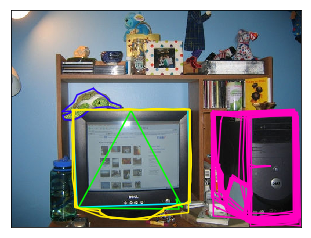

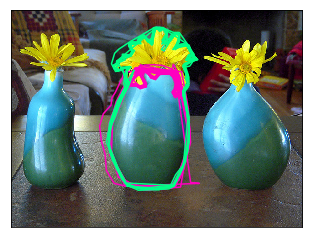

In [59]:
obj_worker_clusters =[]
for objN in objN_lst:
    obj_worker_cluster = better_spectral_clustering(objN[0],objN[1])
    obj_worker_clusters.extend(obj_worker_cluster)